# *M3 - Group Assignment*

We will start out by importing our packages

In [0]:
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import os
import nbconvert
import math

from math import sqrt
from pandas import read_csv, DataFrame, concat
from numpy import concatenate

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence

from keras.layers import Dense, LSTM, Dropout, Activation, Dense, Input, CuDNNLSTM, Embedding, Dropout, SpatialDropout1D, Bidirectional
from keras.layers.normalization import BatchNormalization
from keras.initializers import Constant
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from collections import Counter

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, Imputer
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error

## *Datawrangling and preprocessing*

Here we'll import the dataset, which consists of data from the World development indicators. Which consists mainly of macroeconomic data.

Please note that we exclude some columns originally found, due to the existence of NaN in the respective columns, which could be a problem later on, when we try to do RNN modelling. 

In [0]:
# Let's start by downloading and exploring the data
!wget -qq https://github.com/KristianJoergensen/M3Group/raw/master/worlddata.csv -O df.csv
df = pd.read_csv('df.csv')
df = df.replace('..', numpy.nan)
df = df[df.columns.drop(list(df.filter(regex='health')))]
df = df[df.columns.drop(list(df.filter(regex='education')))]
df = df[df.columns.drop(list(df.filter(regex='debt')))]
df = df[df.columns.drop(list(df.filter(regex='Unemployment')))]
df = df[df.columns.drop(list(df.filter(regex='Current account balance')))]
df = df[df.columns.drop(list(df.filter(regex='Russia')))]
df = df.iloc[0:48,2:]
df.head()

,United States [USA] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],United States [USA] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],United States [USA] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],United States [USA] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],"United States [USA] - Population ages 15-64, total [SP.POP.1564.TO]",United States [USA] - Trade (% of GDP) [NE.TRD.GNFS.ZS],United States [USA] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],United States [USA] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],Denmark [DNK] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],Denmark [DNK] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Denmark [DNK] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],Denmark [DNK] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],"Denmark [DNK] - Population ages 15-64, total [SP.POP.1564.TO]",Denmark [DNK] - Trade (% of GDP) [NE.TRD.GNFS.ZS],Denmark [DNK] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Denmark [DNK] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],United Kingdom [GBR] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],United Kingdom [GBR] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],United Kingdom [GBR] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],United Kingdom [GBR] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],"United Kingdom [GBR] - Population ages 15-64, total [SP.POP.1564.TO]",United Kingdom [GBR] - Trade (% of GDP) [NE.TRD.GNFS.ZS],United Kingdom [GBR] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],United Kingdom [GBR] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],Australia [AUS] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],Australia [AUS] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Australia [AUS] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],Australia [AUS] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],"Australia [AUS] - Population ages 15-64, total [SP.POP.1564.TO]",Australia [AUS] - Trade (% of GDP) [NE.TRD.GNFS.ZS],Australia [AUS] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Australia [AUS] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],China [CHN] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],China [CHN] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],China [CHN] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],China [CHN] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],"China [CHN] - Population ages 15-64, total [SP.POP.1564.TO]",China [CHN] - Trade (% of GDP) [NE.TRD.GNFS.ZS],China [CHN] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],China [CHN] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],...,"Korea, Rep. [KOR] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD]","Korea, Rep. [KOR] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]","Korea, Rep. [KOR] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD]","Korea, Rep. [KOR] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS]","Korea, Rep. [KOR] - Population ages 15-64, total [SP.POP.1564.TO]","Korea, Rep. [KOR] - Trade (% of GDP) [NE.TRD.GNFS.ZS]","Korea, Rep. [KOR] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS]","Korea, Rep. [KOR] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]",Mexico [MEX] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],Mexico [MEX] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Mexico [MEX] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],Mexico [MEX] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],"Mexico [MEX] - Population ages 15-64, total [SP.POP.1564.TO]",Mexico [MEX] - Trade (% of GDP) [NE.TRD.GNFS.ZS],Mexico [MEX] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Mexico [MEX] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],Saudi Arabia [SAU] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],Saudi Arabia [SAU] - GDP 

Now we want to look at the dataset, and get some information about columns

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Columns: 152 entries, United States [USA] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD] to Turkey [TUR] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]
dtypes: object(152)
memory usage: 57.1+ KB


# *Baseline ML model*

Here we define our baseline supervise ML model, here we make a model on the Danish economy, with the same varaibles included, as in the RNN model. Here we make a new varaible names NextBNP, as a target t+1 for Danish GDP. 

In [0]:
dfDK = df.filter(regex='Denmark')
supervised = dfDK
supervised['NextBNP'] = supervised['Denmark [DNK] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD]'].shift(-1)
supervised = supervised[0:47]
values = supervised.values

In [534]:
supervised.tail()

,Denmark [DNK] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],Denmark [DNK] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Denmark [DNK] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],Denmark [DNK] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],"Denmark [DNK] - Population ages 15-64, total [SP.POP.1564.TO]",Denmark [DNK] - Trade (% of GDP) [NE.TRD.GNFS.ZS],Denmark [DNK] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Denmark [DNK] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS],NextBNP
42,327038708765.441,0.226499797192986,58487.7935516956,26.471472471399,3631273,103.240985379852,54.6304891096979,48.6104962701538,330091094980.063
43,330091094980.063,0.93334095714377,58788.0841620279,26.0075127162445,3632226,103.05014595515,54.828812353477,48.2213336016725,335436569747.025
44,335436569747.025,1.61939381227008,59437.9473191651,25.7856363463269,3634226,102.263920935599,54.613119296736,47.6508016388626,343294474735.846
45,343294474735.846,2.34259043214833,60402.1292464226,25.4692179205757,3643647,104.04820103264,55.418153077577,48.6300479550629,351532416441.815
46,351532416441.815,2.3996720926861,61370.7756169795,24.9588599600687,3664797,100.450233712353,53.5939130176726,46.8563206946799,359485376884.199


Here we scale the data and split it between train and test. The test size is 40%

In [0]:
encoder = LabelEncoder()
scaler = StandardScaler()
dataset = supervised.iloc[0:48,:8]
target = supervised.iloc[0:48,8:]
trainX, testX, trainY, testY = train_test_split(dataset, target, test_size=0.40, shuffle=False)

Now we make and fit our model, find the cross validation score and general model performance.

In [0]:
# K-fold cross-validation
model1 = LinearRegression()
scores1 = cross_val_score(model1, trainX, trainY, cv = 2)
print("An average cross validation score of {}".format(numpy.mean(scores1)))

# Model training
model1.fit(trainX, trainY)

# Model performance
print('Model performance:', model1.score(testX, testY))

An average cross validation score of -0.5965846589933168
Model performance: 0.6356794808343882


Here we see a negative cross validation score of -0.597. 
The general model performance is 63.6% which is higher than initially thought. 

This means that the MSE of the model is 0.597, which is quite high compared to the limited data we have.

Now there's an incentive to plot the data, and find how well the prediction of GDP follows actual GDP.

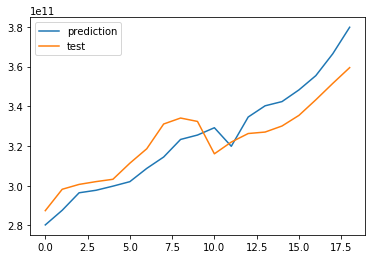

In [0]:
y_pred1 = model1.predict(testX)
testY3 = list(testY['NextBNP'])
testY3 = list(numpy.float_(testY3))

plt.plot(y_pred1, label='prediction')
plt.plot(testY3, label='test')
plt.legend()
plt.savefig('predictionML.png')
plt.show()

As we can see in the plot, the prediction actually follows quite well. With no higher deviations or spikes.

It's surprising to us how well the danish GDP can be predicted from this low amount of data, from Danish national data, without the inclusion of external variables. 

We'll now see if we can improve this by using an RNN model, with the LSTM step.
We'll also expand the first RNN model to include G20 nations, excluding the European union, while including Denmark. Afterwards we'll only look at Denmark, using the same RNN model.

## *Long Short-Term Memory network - RNN - G20 model*

Alright, so what do we want to do?

We want to make a model that could predict a so called "world image", so a model that could predict macroeconomic variables, in a time series dataset. Therefore we have determined that the best course of action would be to use an RNN model, for the LSTM feature that let's us add a time element. 

For the theorists out there, we use a multivariate model approach to the LSTM model, meaning we'll have multiple inputs which we, via multiple parrallel series, predict multiple outputs. This will all be done through a scaled array. This is why you'll find that the model will only have one in- and output, since the array will only be portrayed as one. Since we're working with timeseries, the order of the dataset is of concern, this is why we won't be shuffling the dataset when we split it. 

Since we're working with prediction of time series, we'll not just split the dataset into train and test, but also in- and outputs. Since Y is the predicted value of X, so X = t-1 and Y = t. 

Before we do anything we want to make the results reproducible, this is done by setting the seed. 

In [0]:
# fix random seed for reproducibility
numpy.random.seed(4)

Now we create a little series, where the time variable is created.

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Now we'll load the dataset as a Pandas dataframe. Then we extract the NumPy array from said dataframe and convert it to floating point values for good measure. 

In [0]:
# load the dataset
dataset = df
values = dataset.values
values = values.astype('float32')

We really want to scale our input data, since many of the activation methods used are greatly influenced by the range of the dataset. We'll rescale the dataset to a 0-to-1 dataset, also referred to as normalization. This is done here through the MinMaxScaler. 

In [0]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

We will now reframe the dataset, so we have all our columns as time pieces (t-1) and (t). We end by looking at the shape, since this is important when we need to drop columns.

In [0]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.shape

(38, 304)

Now we need to keep the shape consistent, since we've added 152 columns, we need to delete some, in order to keep it consistent for rescaling. These will be the t-1 columns of the variables, since we don't need them, only the predicted columns (t).

In [0]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150]], axis=1, inplace=True)

Now we'll split the dataset, since we're having a really low amount of observations due to it being macroeconomic data, we'll split it into 75%/25% (36/12)

In [0]:
# split into train and test sets
values = reframed.values
train = values[:36, :]
test = values[12:, :]

We'll split it into inputs and outputs. 

In [0]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

Now we'll reshape the dataset into a 3D input, that can be used, normalle our dataset consists of only samples and features, now we'll need to add the timesteps element. 

In [0]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(36, 1, 152) (36,) (26, 1, 152) (26,)


Now we have the train and test data, in it's 3D form. While y, being the output dimension, is in a singular form. 

We make the model. Notice the LSTM element. Since the model is quite small, we won't use the CuDNNLSTM since it's simply not neccessary. We run the model in under 10 seconds any way. 

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 50)                40600     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 40,651
Trainable params: 40,651
Non-trainable params: 0
_________________________________________________________________


Not that we use the MAE loss function, and the adam optimizer. Sigmoid is the standard output activation layer, which is quite nice, since we have scaled our data from 0-1.

We now run the model, with 100 epochs and validation of the test set. Note the shuffle set to false, as we have with timeseries data, which shouldn't be randomized!!!

In [0]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)

For good measure we plot the loss with the validation loss and get this.

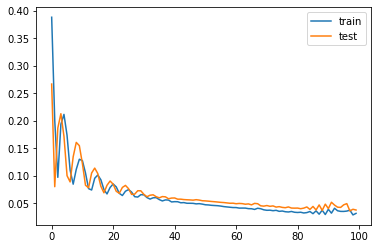

In [0]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig('history.png')
plt.show()

As we see it's converging quite early. Which means that we, in theory, shouldn't use as many epochs as we do, since it'll over specify. Though the end result is quite close to what we want to achieve, so we won't change it for now. 

We'll now make a model prediction. 

First we want to predict when the model is scaled. This is done to get a good glimpse of the actual RMSE value and the individual variables of the model. 

In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [0]:
# calculate RMSE
test_y = test_y.reshape((len(test_y), 1))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Scaled Test RMSE: %.3f' % rmse)

Scaled Test RMSE: 0.005


Here we get a very nice RMSE value of 0.005, which is actually really good for a model this size. 

We now plot the predictions for each variable and get this heap of mess.

No handles with labels found to put in legend.


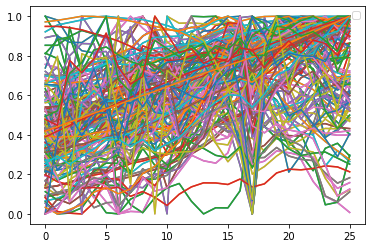

In [0]:
plt.plot(inv_y)
plt.plot(inv_yhat)
plt.legend()
plt.savefig('prediction_scaled.png')
plt.show()

While some patterns can be seen, we mostly see a clutter of lines like a childs drawing. Where we can't really see anything.

If we try to inverse the scaling, we can take a look at the actual numbers of the prediction. We do the same thing again, where we first predict the RMSE and then we only predict a single variable, in this case, the US GDP Constant.

In [0]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

In [0]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [0]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 795496234065.199


As stated before, the RMSE was really nice scaled, as we have a definision of the max and min, this RMSE is really high, which is to be expected when having with macroeconomic data. Also why we like it scaled.

In [0]:
df['United States [USA] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD]'].astype('float32').mean()

10441635921920.0

GDP is:  
10.441.635.921.920

RMSE is:  
795.496.234.065

So RMSE is about 0.076 of GDP.

We will now try to plot it, to see how far off we are.

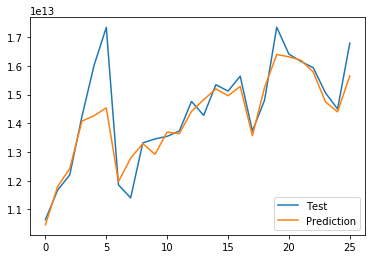

In [0]:
plt.plot(inv_y, label='Test')
plt.plot(inv_yhat, label='Prediction')
plt.legend()
plt.savefig('prediction_unscaled.png')
plt.show()

Our prediction has hit reasonably close. Much closer than our initial thought.

# *We will now do the exact same thing, just for Denmark.*

This has been done for fun and giggles. Nothing major is going on, this is just to see if our prediction would be more or less accurate if we look at 1 country, than all of G20.

Define data

In [0]:
dfDK = df.filter(regex='Denmark')
dfDK.head()

,Denmark [DNK] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD],Denmark [DNK] - GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],Denmark [DNK] - GDP per capita (constant 2010 US$) [NY.GDP.PCAP.KD],Denmark [DNK] - General government final consumption expenditure (% of GDP) [NE.CON.GOVT.ZS],"Denmark [DNK] - Population ages 15-64, total [SP.POP.1564.TO]",Denmark [DNK] - Trade (% of GDP) [NE.TRD.GNFS.ZS],Denmark [DNK] - Exports of goods and services (% of GDP) [NE.EXP.GNFS.ZS],Denmark [DNK] - Imports of goods and services (% of GDP) [NE.IMP.GNFS.ZS]
0,150533749283.215,2.73522976724733,30541.9295946656,20.9618589274781,3174761,57.1346328077322,27.1508585124731,29.9837742952591
1,155057281775.225,3.00499556647537,31241.8588154371,22.3675834894765,3190658,55.6744907654822,26.8244495558747,28.8500412096074
2,161150079790.899,3.92938528646849,32284.2793749532,22.4331211723386,3202373,53.2212142231265,26.4065176139023,26.8146966092243
3,167745865764.592,4.09294614203843,33403.1279966913,21.9601496734949,3216119,57.83977988835,27.9729005136744,29.8668793746756
4,165863095709.072,-1.12239431173965,32874.7932399365,23.647424134623,3228186,64.6614281790602,30.6563986526804,34.0050295263798


Make time steps

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Scale and reframe

In [0]:
# load the dataset
dataset = dfDK
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.shape
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2,3,4,5,6]], axis=1, inplace=True)

Split in train/test and input/output

In [0]:
# split into train and test sets
values = reframed.values
train = values[:36, :]
test = values[12:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(36, 1, 8) (36,) (35, 1, 8) (35,)


Design network, fit and plot

In [0]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=36, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.savefig('historyDK.png')
plt.show()

Make prediction

In [0]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# calculate RMSE
test_y = test_y.reshape((len(test_y), 1))
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Scaled Test RMSE: %.3f' % rmse)

Scaled Test RMSE: 0.014


Her we, yet again, get a value of RMSE that is quite low, which is nice.

Plot prediction

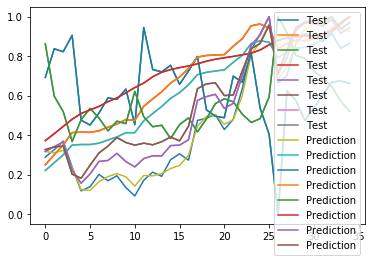

In [0]:
# Plot predictions on test
plt.plot(inv_y, label='Test')
plt.plot(inv_yhat, label='Prediction')
plt.legend()
plt.savefig('prediction_scaledDK.png')
plt.show()

Inverse scaling, predict,

In [0]:
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8513133790.076


Our RMSE is high, which is yet again expectated. 

We calculate the mean GDP in order to relate it to the RMSE value.

In [0]:
dfDK['Denmark [DNK] - GDP (constant 2010 US$) [NY.GDP.MKTP.KD]'].astype('float32').mean()

253067706368.0

GDP is:  
253.067.706.368

RMSE is:  
8.513.133.790

So RMSE is about 0.034 of GDP.

Plot prediction.

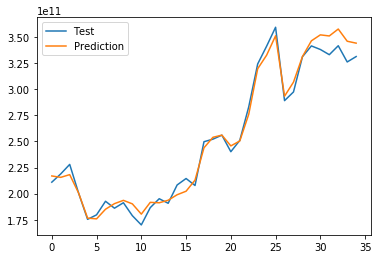

In [0]:
# Plot predictions on test
plt.plot(inv_y, label='Test')
plt.plot(inv_yhat, label='Prediction')
plt.legend()
plt.savefig('prediction_unscaledDK.png')
plt.show()

As we can see, the prediction follows the actual value quite nicely.